Original paper: https://arxiv.org/abs/1806.00035

# 0. Read real and generated images#

In [56]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [57]:
%cd /content/gdrive/My Drive/Colab Notebooks/HW3
%ls

/content/gdrive/My Drive/Colab Notebooks/HW3
BBBC018_v1_images-fixed/                    homework03_part3_gan_basic.ipynb
BBBC018_v1_outlines/                        lfw/
data.zip                                    lfw_attributes.txt
gan1.npz                                    lfw_dataset.py
gan.npz                                     lfw-deepfunneled/
homework03_part1_both.ipynb                 linear.png
homework03_part2_autoencoders_basic.ipynb   __pycache__/
homework03_part2_vae_advanced.ipynb         real.npz
homework03_part3a_gan_advanced.ipynb        simple_1d_gan_pytorch.ipynb
homework03_part3b_prd_score_advanced.ipynb  vae.npz


In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib

In [0]:
CHANNEL_NUM = 3
PICTURE_SIZE = 36


In [0]:
class ParticleDataset():
    def __init__(self, file):
        self.data = np.load(file)
        self.image = self.data['Pictures'].reshape(-1, CHANNEL_NUM*PICTURE_SIZE*PICTURE_SIZE)

    def __len__(self):
        return len(self.image)

    def __getitem__(self, i):
        return {
            "Pictures": self.image[i],
        }

In [0]:
real_data = ParticleDataset('real.npz')
vae_data = ParticleDataset('vae.npz')
gan_data = ParticleDataset('gan1.npz')

Make sure that the values of real and generated data are of the same order - it is important for cooperative binarizing

In [69]:
print (np.min(real_data.image), np.max(real_data.image))
print (np.min(gan_data.image), np.max(gan_data.image))
print (np.min(vae_data.image), np.max(vae_data.image))

0.0 1.0
0.0 1.0
-0.8294658720775064 1.7013868175754723


# 1. Binarize# 

To understand how real and generated objects are close to each other, we need to choose a space of features in which we look these objects at

We go the easiest way and take pixels' values as features.

In [0]:
#source https://github.com/msmsajjadi/precision-recall-distributions/blob/master/prd_score.py
from sklearn.cluster import KMeans, MiniBatchKMeans
import math
import sklearn
## function which map object to probability distribution ##

def bin_counts (real_data, generated_data, number_of_bins=25):
    cluster_data=np.vstack([real_data,generated_data])
    kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=number_of_bins, n_init=10)
    labels = kmeans.fit(cluster_data).labels_
    eval_labels = labels[:len(real_data)]
    ref_labels = labels[len(real_data):]
    real_density = np.histogram(eval_labels, bins=number_of_bins,
                           range=[0, number_of_bins], density=True)[0]
    gen_density = np.histogram(ref_labels, bins=number_of_bins,
                          range=[0, number_of_bins], density=True)[0]
    # binirize real and generated data, plot histogram and found density function
    return real_density, gen_density

Create $\alpha-$ and $\beta-$ vectors as in

$\hat{PRD}(Q,P) = \{(\alpha(\lambda), \beta(\lambda))| \lambda \in \Lambda \}$, where $\Lambda = \{\tan (\frac{i}{m+1} \frac{\pi}{2}) | i = 1, 2 ... m\}$

In [0]:
#source https://github.com/msmsajjadi/precision-recall-distributions/blob/master/prd_score.py
def count_alpha_beta (real_density, gen_density, num_angles = 1000):
    assert real_density.shape == gen_density.shape
#     alpha_vec = []
#     beta_vec = []
    angles = np.linspace(1e-6, np.pi/2 - 1e-6, num=num_angles)
    # you code
    slopes = np.tan(angles)
    slopes_2d=np.expand_dims(slopes,1)
    
    
    slopes_2d = np.expand_dims(slopes, 1)

  # Broadcast distributions so that first dimension represents the angles
    ref_dist_2d = np.expand_dims(real_density, 0)
    eval_dist_2d = np.expand_dims(gen_density, 0)

  # Compute precision and recall for all angles in one step via broadcasting
    alpha_vec = np.minimum(ref_dist_2d*slopes_2d, eval_dist_2d).sum(axis=1)
    beta_vec = alpha_vec / slopes
    alpha_vec=alpha_vec.ravel()
    beta_vec=beta_vec.ravel()
    return alpha_vec, beta_vec

For stability, take the average of several repetitions

In [0]:
def count_prd(reals, gens, repeat_number = 10):
    vectors = [count_alpha_beta(reals, gens) for i in range(repeat_number)]
    vectors = np.array(vectors).mean(axis=0)
    print (vectors.shape)
    return vectors

## 2. Apply it##

In [0]:
a, b = bin_counts(real_data.image, vae_data.image)
c, d = bin_counts(real_data.image, gan_data.image)

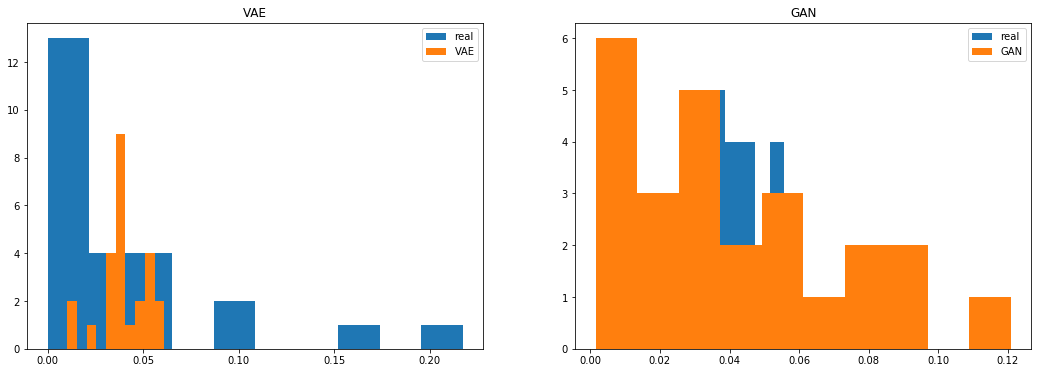

In [84]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.hist(a,label='real')
plt.hist(b,label='VAE')
plt.title('VAE')
plt.legend()
plt.subplot(1,2,2)
plt.hist(c,label='real')
plt.hist(d,label='GAN')
plt.title('GAN')
plt.legend()

## 3. Make vectors for plot and plot ##

In [77]:
data_for_plots = count_prd(a, b)
data_for_plots2 = count_prd(c, d)

(2, 1000)
(2, 1000)


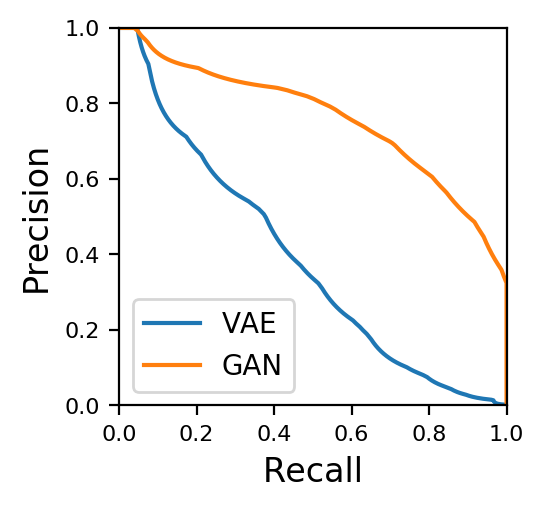

In [78]:
fig = plt.figure(figsize=(2.5, 2.5), dpi=200)
fig.add_subplot(111).tick_params(axis='both', which='major', labelsize=8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.plot(data_for_plots[0], data_for_plots[1], label = "VAE")
plt.plot(data_for_plots2[0], data_for_plots2[1], label = "GAN")
plt.legend()
plt.show()

**What curves were obtained for the first(VAE) and the second(GAN) models? What can we say about the advantages and disadvantages of each model?**

#type answer here
According to this plot, we can see that GAN show better Precision in the same recall level as VAE. 

**VAE** advantages:
-it is often necessary to change or investigate data options. In this case, VAEs work better than any other currently available method.
**GAN advantages**:
-Generative adversarial networks were designed to avoid using Markov chains because of the high computational cost of the latter.
-relative to Boltzmann machines is that the Generator function has much fewer restrictions (there are only a few probability distributions that admit Markov chain sampling).

## Bonus: about features' space##

It is possible to transfer the picture-> embedding, for example, using the 1st part of the Inception network as a feature extraxtor. This embedding can be used for bin counts also

In [0]:
# if you came here and still alive, the implementation of idea above will give you extra points =)
